In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [5]:
df_with_infertility = "Z:\PCOS-detect\FormPCOS\pcosData\PCOS_infertility.csv"
df_without_infertility = "Z:\PCOS-detect\FormPCOS\pcosData\PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(df_with_infertility)
PCOS_woinf = pd.read_excel(df_without_infertility, sheet_name="Full_new")

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\dashp\AppData\Local\Temp\ipykernel_27064\647071150.py:1: SyntaxWarning: invalid escape sequence '\P'
  df_with_infertility = "Z:\PCOS-detect\FormPCOS\pcosData\PCOS_infertility.csv"
C:\Users\dashp\AppData\Local\Temp\ipykernel_27064\647071150.py:2: SyntaxWarning: invalid escape sequence '\P'
  df_without_infertility = "Z:\PCOS-detect\FormPCOS\pcosData\PCOS_data_without_infertility.xlsx"


In [6]:
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes=('', '_y'), how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y',
                  '  I   beta-HCG(mIU/mL)_y', 'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)
data = data.dropna()

In [7]:
X = data.drop(columns=['PCOS (Y/N)', 'Sl. No.', 'Patient File No.'], errors='ignore')
y = data['PCOS (Y/N)']

In [8]:
non_numeric_cols = X.select_dtypes(include='object').columns
for col in non_numeric_cols:
    X[col] = pd.to_numeric(X[col].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

In [9]:
X = X.fillna(X.mean())

In [10]:
nan_columns = X.columns[X.isnull().any()].tolist()
if nan_columns:
    print("Dropping columns with remaining NaNs:", nan_columns)
    X = X.drop(columns=nan_columns)
else:
    print("No NaNs remaining in the data")

Dropping columns with remaining NaNs: ['AMH(ng/mL)']


In [11]:
print(X)

     Sl. No   Age (yrs)  Weight (Kg)  Height(Cm)         BMI  Blood Group  \
0         1          28         44.6      152.000  19.300000           15   
1         2          36         65.0      161.500  24.921163           15   
2         3          33         68.8      165.000  25.270891           11   
3         4          37         65.0      148.000  29.674945           13   
4         5          25         52.0      161.000  20.060954           11   
..      ...         ...          ...          ...        ...          ...   
536     537          35         50.0      164.592  18.500000           17   
537     538          30         63.2      158.000  25.300000           15   
538     539          36         54.0      152.000  23.400000           13   
539     540          27         50.0      150.000  22.200000           15   
540     541          23         82.0      165.000  30.100000           13   

     Pulse rate(bpm)   RR (breaths/min)  Hb(g/dl)  Cycle(R/I)  ...  \
0    

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [15]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


x:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stop])


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5984 - loss: 0.6508 - val_accuracy: 0.7759 - val_loss: 0.5261
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8490 - loss: 0.4488 - val_accuracy: 0.8103 - val_loss: 0.3795
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8938 - loss: 0.2799 - val_accuracy: 0.8534 - val_loss: 0.3517
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9415 - loss: 0.2075 - val_accuracy: 0.8966 - val_loss: 0.3103
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9109 - loss: 0.2299 - val_accuracy: 0.8966 - val_loss: 0.3061
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9370 - loss: 0.1845 - val_accuracy: 0.9052 - val_loss: 0.2908
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9246 - loss: 0.1948 - val_accuracy: 0.8966 - val_loss: 0.2878
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9299 - loss: 0.1534 - val_accuracy: 0.8879 - v

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9092 - loss: 0.2827 
Test Accuracy: 0.92


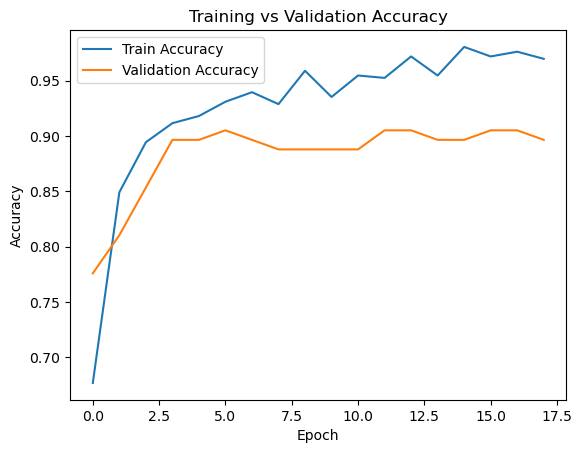

In [18]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

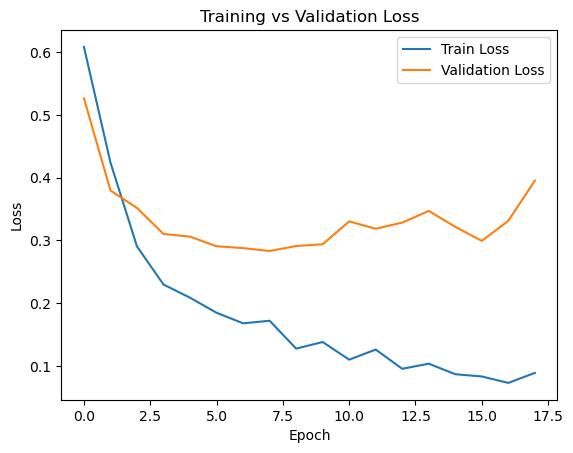

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


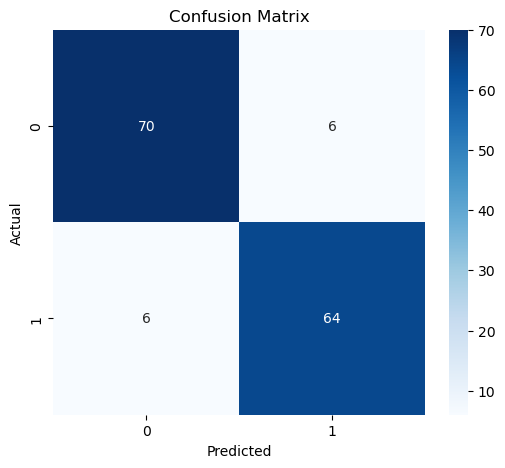

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        76
           1       0.91      0.91      0.91        70

    accuracy                           0.92       146
   macro avg       0.92      0.92      0.92       146
weighted avg       0.92      0.92      0.92       146



In [20]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred))


In [21]:
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {auc:.2f}")


AUC-ROC Score: 0.97


In [22]:
# Save the trained model to a .h5 file
model.save('pcos_model.h5')


In [23]:
import joblib
scaler = joblib.load("scaler.pkl")


In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import joblib

# Load the trained model and scaler
model = load_model("pcos_model.h5")
scaler = joblib.load("scaler.pkl")  # Correct filename

# Define encoding for categorical features
blood_group_map = {"A+": 0, "A-": 1, "B+": 2, "B-": 3, "O+": 4, "O-": 5, "AB+": 6, "AB-": 7}
cycle_map = {"Regular": 0, "Irregular": 1}

# Get user input
input_data = {}

# Optional binary features
for feature in [
    ("skin_darkening", "Skin Darkening (1 for Yes, 0 for No): "),
    ("hair_growth", "Hair Growth (1 for Yes, 0 for No): "),
    ("weight_gain", "Weight Gain (1 for Yes, 0 for No): "),
    ("fast_food", "Fast Food (1 for Yes, 0 for No): "),
    ("pimples", "Pimples (1 for Yes, 0 for No): "),
    ("hair_loss", "Hair Loss (1 for Yes, 0 for No): ")
]:
    val = input(f"{feature[1]} (press Enter to skip): ")
    if val.strip() != "":
        input_data[feature[0]] = int(val)

# Optional continuous features
for feature in [
    ("height", "Height (in cm): "),
    ("weight", "Weight (in kg): "),
    ("bmi", "BMI: ")
]:
    val = input(f"{feature[1]} (press Enter to skip): ")
    if val.strip() != "":
        input_data[feature[0]] = float(val)

# Cycle regularity (categorical)
cycle = input("Cycle Regularity (Regular/Irregular) (press Enter to skip): ").capitalize()
if cycle in cycle_map:
    input_data["cycle_regularity"] = cycle

# Blood group (categorical)
blood = input("Blood Group (e.g., A+, B-, O+) (press Enter to skip): ").upper()
if blood in blood_group_map:
    input_data["blood_group"] = blood

# Build feature vector (partial to full with padding)
processed = []

# Manually extract features in preferred order
for feat in [
    "skin_darkening", "hair_growth", "weight_gain", "fast_food",
    "pimples", "hair_loss", "height", "weight", "bmi",
    "cycle_regularity", "blood_group"
]:
    if feat in input_data:
        if feat == "cycle_regularity":
            processed.append(cycle_map[input_data[feat]])
        elif feat == "blood_group":
            processed.append(blood_group_map[input_data[feat]])
        else:
            processed.append(input_data[feat])

# Pad with zeros up to 41 features expected by the scaler
processed_padded = processed + [0] * (41 - len(processed))

# Convert to array and scale
features_np = np.array(processed_padded).reshape(1, -1)
features_scaled = scaler.transform(features_np)

# Predict
prediction = model.predict(features_scaled)

# Show raw probability
print("Raw prediction value:", prediction[0][0])
print(f"PCOS chance: {round(prediction[0][0] * 100, 2)}%")

# Convert to label
result = "Yes" if prediction[0][0] > 0.5 else "No"
print(f"\nPCOS Prediction: {result}")


x:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Raw prediction value: 6.4168216e-06
PCOS chance: 0.0%

PCOS Prediction: No
